In [1]:
import os
import time
import numpy as np
import pandas as pd
#from sklearnex import patch_sklearn #use intel patch before importing sklearn
#patch_sklearn()
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn import linear_model, svm, tree, ensemble, neighbors
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import lightgbm as lgbm

## Loading Data

In [2]:
fullData = pd.read_csv("../HGS/clean_dataset_v3.csv", sep=",")
fullData = fullData.drop(columns=["S7", "S13"])

In [3]:
instanceData = fullData[fullData["instance_name"].str.find("3113") > 0]
chunkData = fullData.sample(10000, random_state=123456)
if "instance_name" in chunkData.columns:
    chunkData = chunkData.drop(columns=["instance_name"])

del fullData

In [79]:
#I shouldn't standarize the whole set
#chunkData = pd.DataFrame(preprocessing.StandardScaler().fit_transform(chunkData), columns=colNames)

nbrLabels = 2

separators = np.quantile(chunkData["cost"], [i/nbrLabels for i in range(0, nbrLabels+1)])
print(separators)
labelCols = []
#labelize data
for i in range(1, nbrLabels+1):
    labelCols.append("top"+str(i/nbrLabels))
    if i < nbrLabels:
        chunkData["top"+str(i/nbrLabels)] = (separators[i-1] <= chunkData["cost"]) & (chunkData["cost"] < separators[i])
    else:
        chunkData["top"+str(i/nbrLabels)] = (separators[i-1] <= chunkData["cost"]) & (chunkData["cost"] <= separators[i])
    chunkData.loc[chunkData["top"+str(i/nbrLabels)], "label"] = i

chunkData["label"] = chunkData["label"].astype(int)
chunkData.head()

[ 7791. 18345. 26322.]


,cost,S1,S2,S3,S4,S5,S6,S8,S9,S10,S11,S12,S14,S15,S16,S17,S18,top0.5,top1.0,label
12800051,14483,131.402,99.7370,0.0847,0.0643,559.667,299.700,448.750,0.3663,0.0872,805.167,0.3704,0.2457,637.502,345.401,2.2111,4.1302,True,False,1
5483954,10406,137.274,64.4632,0.1157,0.0859,454.500,100.664,293.000,0.2868,0.1268,525.600,0.2123,0.0329,249.455,352.032,1.8974,3.8180,True,False,1
10788912,20900,162.031,93.7861,0.0574,0.0474,973.900,281.018,759.600,0.3692,0.0821,1421.000,0.3636,0.2727,593.597,437.968,3.0000,4.7000,False,True,2
8346315,21353,230.727,149.5370,0.1096,0.0606,803.167,322.533,641.167,0.3607,0.1160,1117.000,0.3704,0.2457,724.450,496.813,2.2111,3.4688,False,True,2
134772,14324,266.923,133.4720,0.2667,0.2520,473.333,171.891,348.583,0.3057,0.1183,592.333,0.3704,0.2457,443.784,472.126,2.2111,2.9479,True,False,1


In [77]:
y = chunkData["label"]
x = chunkData.drop(columns=labelCols + ["cost"] + ["label"])

In [78]:
y.describe()

count    10000.000000
mean         1.500000
std          0.500025
min          1.000000
25%          1.000000
50%          1.500000
75%          2.000000
max          2.000000
Name: label, dtype: float64

## Utils
### Training methods

In [67]:
def model_cv_rapport(model , name  : str, x : np.array, y : np.array, cv=5, precision = 8):
    """
    Apply the model then cross validate and export its score 
    """
    #making sure data is standarized
    pipe = Pipeline([
        ('scale', preprocessing.StandardScaler()),
        ('clf', model)
    ])
    score = cross_validate(pipe, x, y, cv=cv,
                           scoring=["precision", "recall", "f1", "roc_auc", "accuracy"],
                           verbose=10,
                           n_jobs=-1)
    print (name, "--------------------------------------")
    print("Precision: ", round(score["test_precision"].mean(), precision))
    print("Recall: ", round(score["test_recall"].mean(), precision))
    print("F1: ", round(score["test_f1"].mean(), precision))
    print("ROC: ", round(score["test_roc_auc"].mean(), precision))
    print("Accuracy: ", round(score["test_accuracy"].mean(), precision))

In [68]:
def grid_search(grid, model, x_train, y_train, cv=5, verbose=10):
    #making sure data is standarized
    pipe = Pipeline([
        ('scale', preprocessing.StandardScaler()),
        ('clf', model)
    ])

    #modifying grid params to match pipeline
    newGrid = [{}]
    for key, item in grid.items():
        newGrid[0]["clf__"+key] = item

    logreg_cv=GridSearchCV(pipe,param_grid=newGrid,cv=cv, verbose=verbose, scoring="f1")
    logreg_cv.fit(x_train,y_train)
    print("tuned hyperparameters :(best parameters) ",logreg_cv.best_params_)
    print("accuracy :",logreg_cv.best_score_)
    return logreg_cv

### Plotting methods

In [69]:
def plotGridResults(logreg_cv, x_axis_prec=4):
    nbrParam = len(logreg_cv.cv_results_["params"])
    nSplits = logreg_cv.n_splits_
    scores = [[] for i in range(nbrParam)]
    for i in range(nbrParam):
        for j in range(nSplits):
            scores[i].append(logreg_cv.cv_results_["split"+str(j)+"_test_score"][i])

    labels = []
    for param in logreg_cv.cv_results_["params"]:
        for name, value in param.items():
            if type(value) == str:
                labels.append(value)
            else:
                labels.append(str(round(value,x_axis_prec)))
    plt.figure(figsize=(20,10))
    plt.boxplot(scores, labels=labels)

## Models

In [70]:
def confusion_matrix(Y_pred, Y_test):
    plt.title('Distribution des coûts', fontdict={'fontsize': 10})
    n_samples = Y_pred.shape[0]
    n_classes = Y_pred.shape[1]
    C = np.zeros((n_classes, n_classes))
    for i in range(n_samples):
        cpred = np.argmax(Y_pred[i])
        ctest = np.argmax(Y_test[i])
        C[cpred, ctest] += 1
    plt.figure(figsize=(5, 5))
    plt.imshow(C, cmap='viridis')
    plt.colorbar(shrink=0.8)
    plt.xticks(np.arange(n_classes), np.arange(n_classes) + 1)
    plt.yticks(np.arange(n_classes), np.arange(n_classes) + 1)
    plt.xlabel("pred", size=13)
    plt.ylabel("true", size=13)
    return C

"""
c1 = [1, 0, 0, 0]
c2 = [0, 1, 0, 0]
c3 = [0, 0, 1, 0]
c4 = [0, 0, 0, 1]
a = np.array([c3, c3, c4, c2, c1, c1, c4])
b = np.array([c4, c3, c4, c4, c1, c1, c2])
confusion_matrix(a, b)"""

'\nc1 = [1, 0, 0, 0]\nc2 = [0, 1, 0, 0]\nc3 = [0, 0, 1, 0]\nc4 = [0, 0, 0, 1]\na = np.array([c3, c3, c4, c2, c1, c1, c4])\nb = np.array([c4, c3, c4, c4, c1, c1, c2])\nconfusion_matrix(a, b)'

# Support Vector Classification

In [80]:
#Setting model
model = svm.SVC(kernel="rbf", gamma="scale")

SVC()

In [81]:
model_cv_rapport(model, "Non tuned SVC", x, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.4s remaining:    0.2s


Non tuned SVC --------------------------------------
Precision:  1.0
Recall:  0.9962
F1:  0.99809534
ROC:  0.9998268
Accuracy:  0.9981


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


### Hyperparameters - SVC

#### kernel param

In [82]:
#Testing kernel parameter
grid={#"C":np.logspace(-3,3,7),
      "kernel": ["linear", "poly", "rbf", "sigmoid"]}
      #"epsilon":np.logspace(-3,3,7),
      #"gamma": np.logspace(-3,3,7)}
model=svm.SVC()
results = grid_search(grid, model, x, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START clf__kernel=linear..........................................
[CV 1/5; 1/4] END ...........clf__kernel=linear;, score=0.997 total time=   0.0s
[CV 2/5; 1/4] START clf__kernel=linear..........................................
[CV 2/5; 1/4] END ...........clf__kernel=linear;, score=1.000 total time=   0.0s
[CV 3/5; 1/4] START clf__kernel=linear..........................................
[CV 3/5; 1/4] END ...........clf__kernel=linear;, score=0.997 total time=   0.0s
[CV 4/5; 1/4] START clf__kernel=linear..........................................
[CV 4/5; 1/4] END ...........clf__kernel=linear;, score=0.998 total time=   0.0s
[CV 5/5; 1/4] START clf__kernel=linear..........................................
[CV 5/5; 1/4] END ...........clf__kernel=linear;, score=0.998 total time=   0.0s
[CV 1/5; 2/4] START clf__kernel=poly............................................
[CV 1/5; 2/4] END .............clf__kernel=poly;,

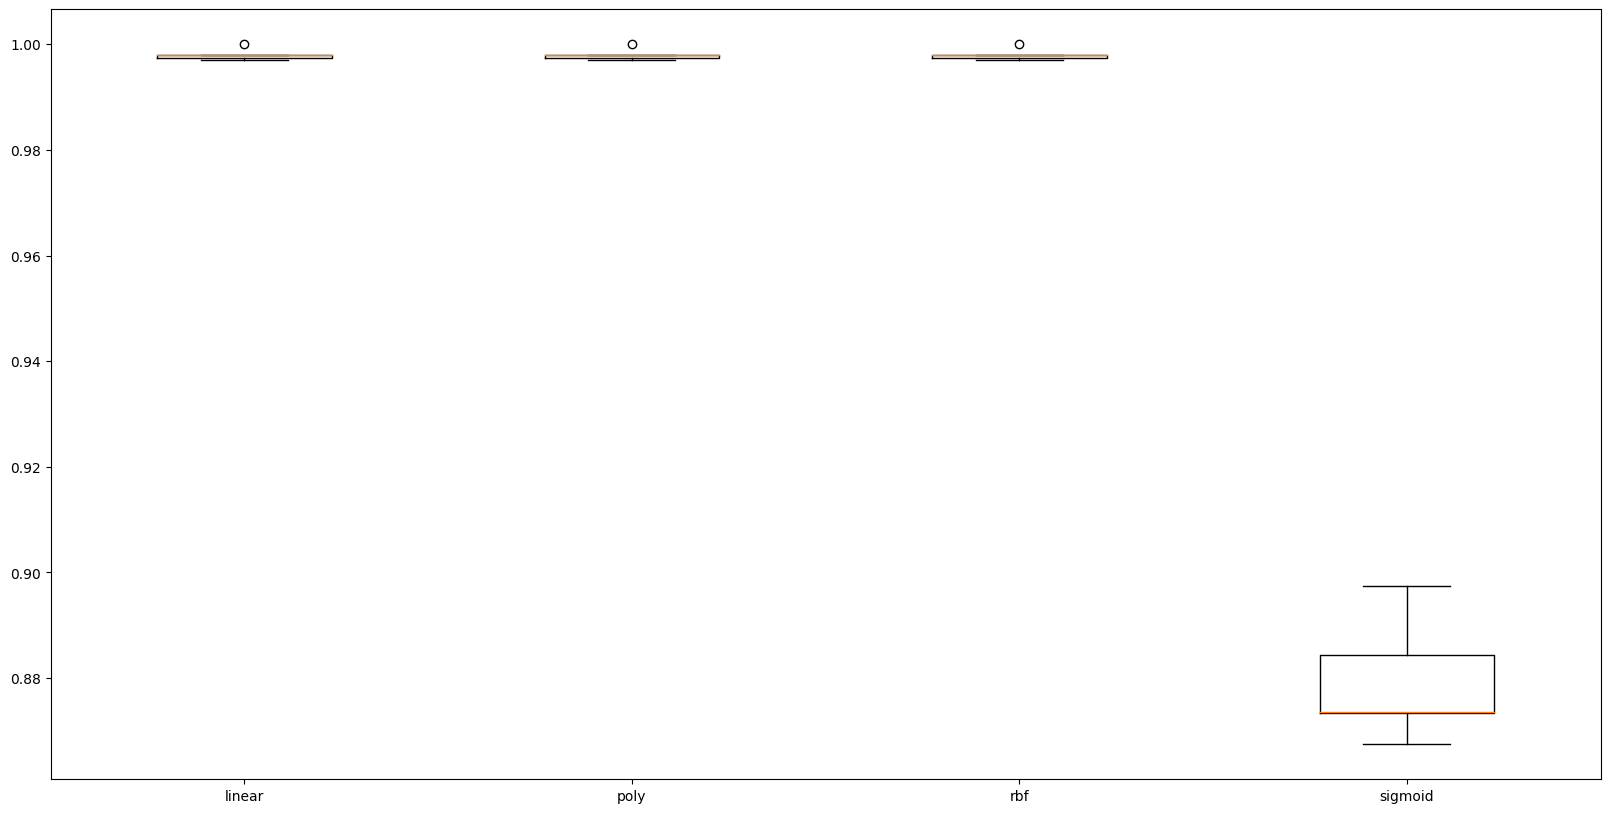

In [83]:
plotGridResults(results)

#### C param

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5; 1/7] START clf__C=0.1..................................................
[CV 1/5; 1/7] END ...................clf__C=0.1;, score=0.997 total time=   0.0s
[CV 2/5; 1/7] START clf__C=0.1..................................................
[CV 2/5; 1/7] END ...................clf__C=0.1;, score=1.000 total time=   0.1s
[CV 3/5; 1/7] START clf__C=0.1..................................................
[CV 3/5; 1/7] END ...................clf__C=0.1;, score=0.997 total time=   0.1s
[CV 4/5; 1/7] START clf__C=0.1..................................................
[CV 4/5; 1/7] END ...................clf__C=0.1;, score=0.998 total time=   0.2s
[CV 5/5; 1/7] START clf__C=0.1..................................................
[CV 5/5; 1/7] END ...................clf__C=0.1;, score=0.998 total time=   0.2s
[CV 1/5; 2/7] START clf__C=0.46415888336127786..................................
[CV 1/5; 2/7] END ...clf__C=0.46415888336127786;,

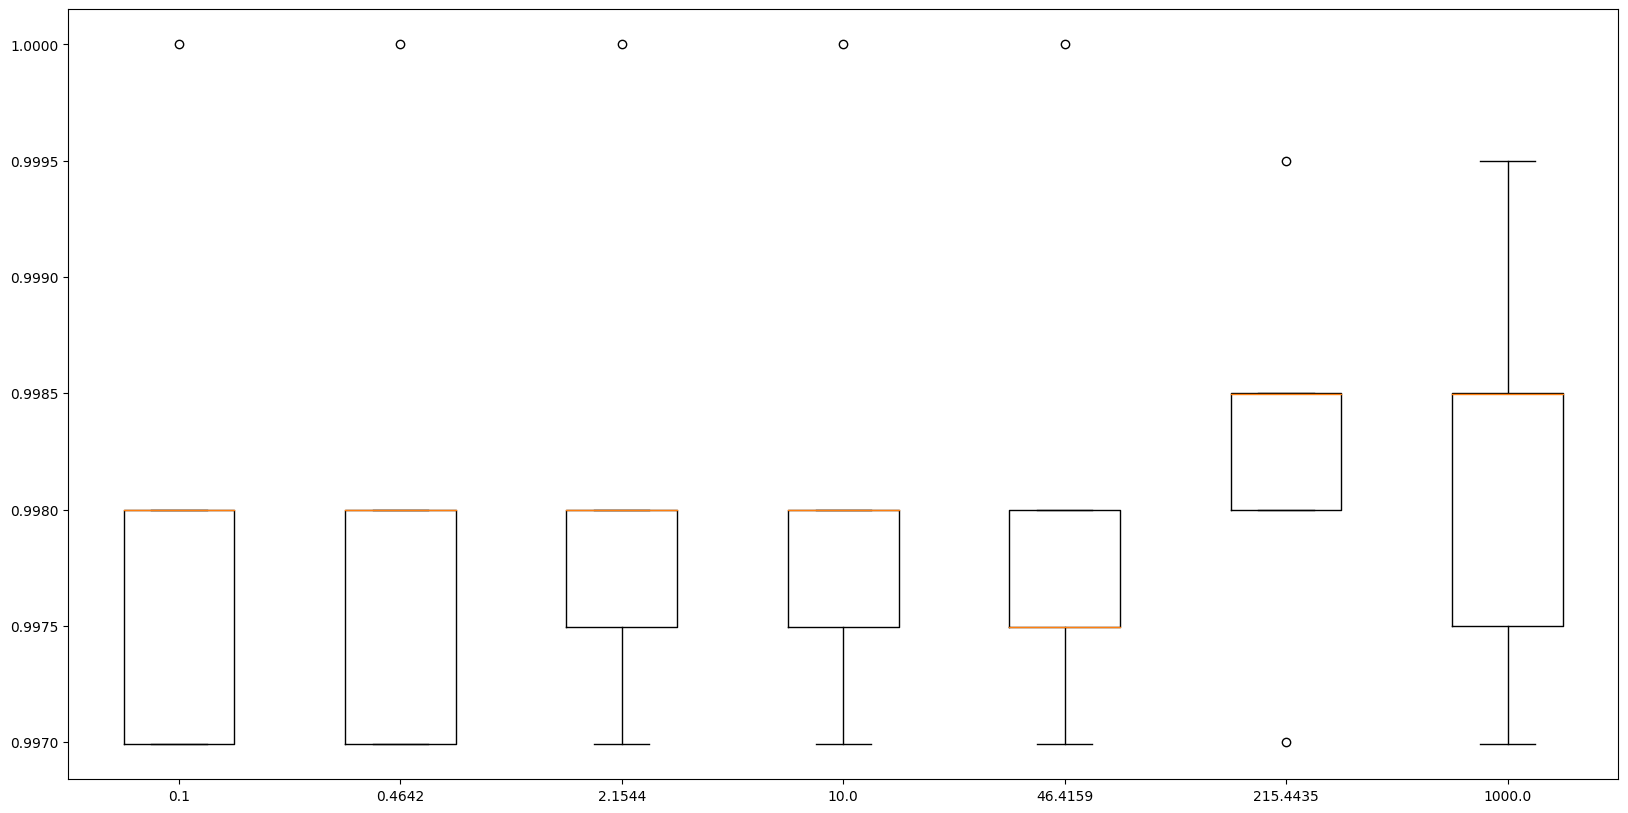

In [84]:
#Testing C parameter
grid={"C":np.logspace(-1,3,7)}
      #"kernel": ["rbf"]
      #"epsilon":np.logspace(-3,3,7),
      #"gamma": np.logspace(-3,3,7)}
model=svm.SVC(kernel="linear")
Cresults = grid_search(grid, model, x, y)
plotGridResults(Cresults)

We choose C = 215 as the variance is far lower than for 1000

#### Best hyperparameters

In [85]:
#Setting model
model = svm.SVC(kernel="linear", C=215)
model_cv_rapport(model, "tuned SVC", x, y)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1803s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


tuned SVC --------------------------------------
Precision:  0.9991998
Recall:  0.9974
F1:  0.99829855
ROC:  0.9999604
Accuracy:  0.9983


### Best SVC eval

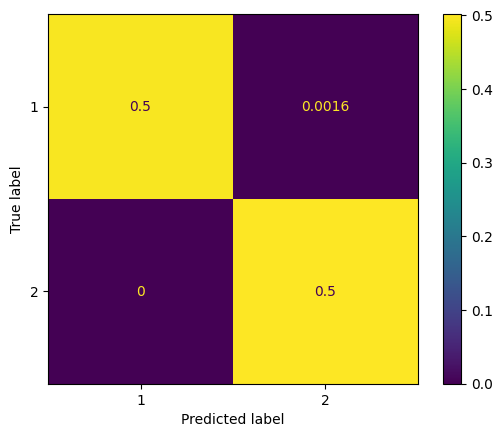

In [86]:
model = svm.SVC(kernel="linear", C=1000)
pipe = Pipeline([('scaler', preprocessing.StandardScaler()), ('svc', model)])
x_train, x_test, y_train, y_test = train_test_split(x.values, y.values)
pipe.fit(x_train, y_train)
ConfusionMatrixDisplay.from_estimator(pipe, x_test, y_test, cmap="viridis", normalize="all")

# Random Forest

In [88]:
model = ensemble.RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=None #"sqrt", "log2", int, float
)
model_cv_rapport( model, "RF", x, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.4s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.5s remaining:    2.3s


RF --------------------------------------
Precision:  0.99799819
Recall:  0.9968
F1:  0.99739739
ROC:  0.9997686
Accuracy:  0.9974


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.2s finished


Ploting the Feature importance

<AxesSubplot: ylabel='feature name'>

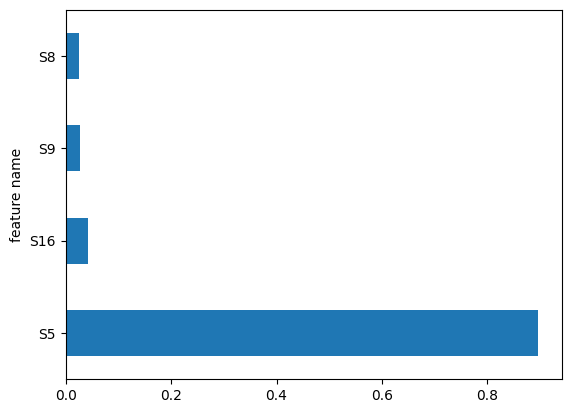

In [90]:
model.fit(x,y)
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(4).plot(xlabel= "feature name",   kind='barh')

### Hyperparameters - RF
Based on [this article](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/), for all RF based algorithms, I first need to pick a learning rate (except for RF), then the number of estimators, and then I can tune the tree parameters.

#### n_estimators param

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV 1/10; 1/6] START clf__n_estimators=10.......................................
[CV 1/10; 1/6] END ........clf__n_estimators=10;, score=0.998 total time=   0.0s
[CV 2/10; 1/6] START clf__n_estimators=10.......................................
[CV 2/10; 1/6] END ........clf__n_estimators=10;, score=0.996 total time=   0.0s
[CV 3/10; 1/6] START clf__n_estimators=10.......................................
[CV 3/10; 1/6] END ........clf__n_estimators=10;, score=0.997 total time=   0.0s
[CV 4/10; 1/6] START clf__n_estimators=10.......................................
[CV 4/10; 1/6] END ........clf__n_estimators=10;, score=1.000 total time=   0.0s
[CV 5/10; 1/6] START clf__n_estimators=10.......................................
[CV 5/10; 1/6] END ........clf__n_estimators=10;, score=0.999 total time=   0.0s
[CV 6/10; 1/6] START clf__n_estimators=10.......................................
[CV 6/10; 1/6] END ........clf__n_estimators=10;

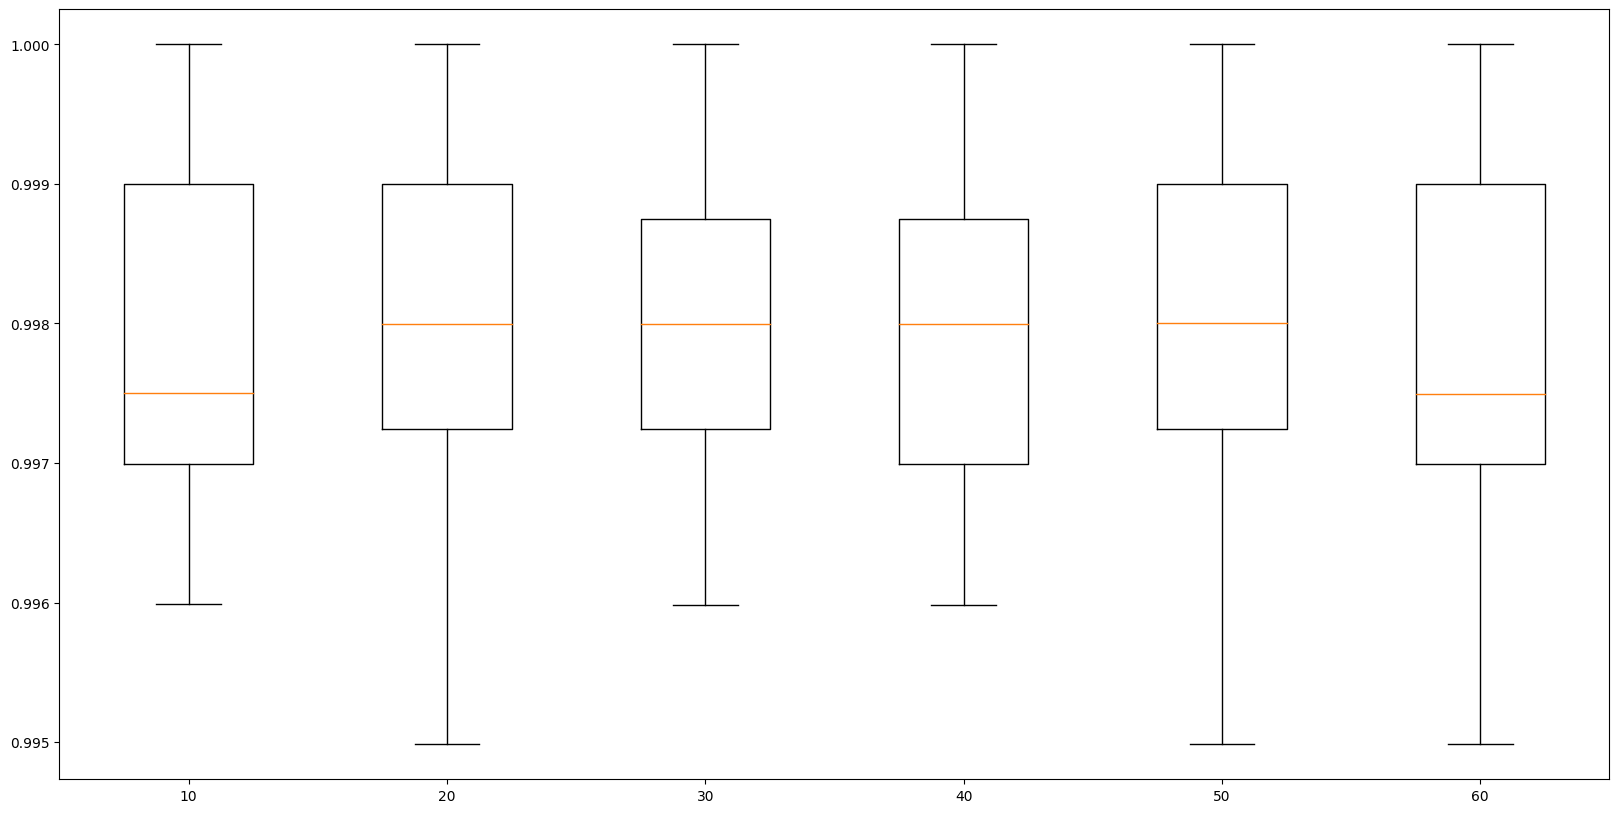

In [92]:
grid={"n_estimators":[i*10 for i in range(1, 7)]}
model=ensemble.RandomForestClassifier()
results = grid_search(grid, model, x, y, cv=10)
plotGridResults(results)

#### max_depth param

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START clf__max_depth=2...........................................
[CV 1/5; 1/10] END ............clf__max_depth=2;, score=0.966 total time=   0.0s
[CV 2/5; 1/10] START clf__max_depth=2...........................................
[CV 2/5; 1/10] END ............clf__max_depth=2;, score=0.973 total time=   0.1s
[CV 3/5; 1/10] START clf__max_depth=2...........................................
[CV 3/5; 1/10] END ............clf__max_depth=2;, score=0.970 total time=   0.0s
[CV 4/5; 1/10] START clf__max_depth=2...........................................
[CV 4/5; 1/10] END ............clf__max_depth=2;, score=0.969 total time=   0.1s
[CV 5/5; 1/10] START clf__max_depth=2...........................................
[CV 5/5; 1/10] END ............clf__max_depth=2;, score=0.974 total time=   0.1s
[CV 1/5; 2/10] START clf__max_depth=3...........................................
[CV 1/5; 2/10] END ............clf__max_depth=3;

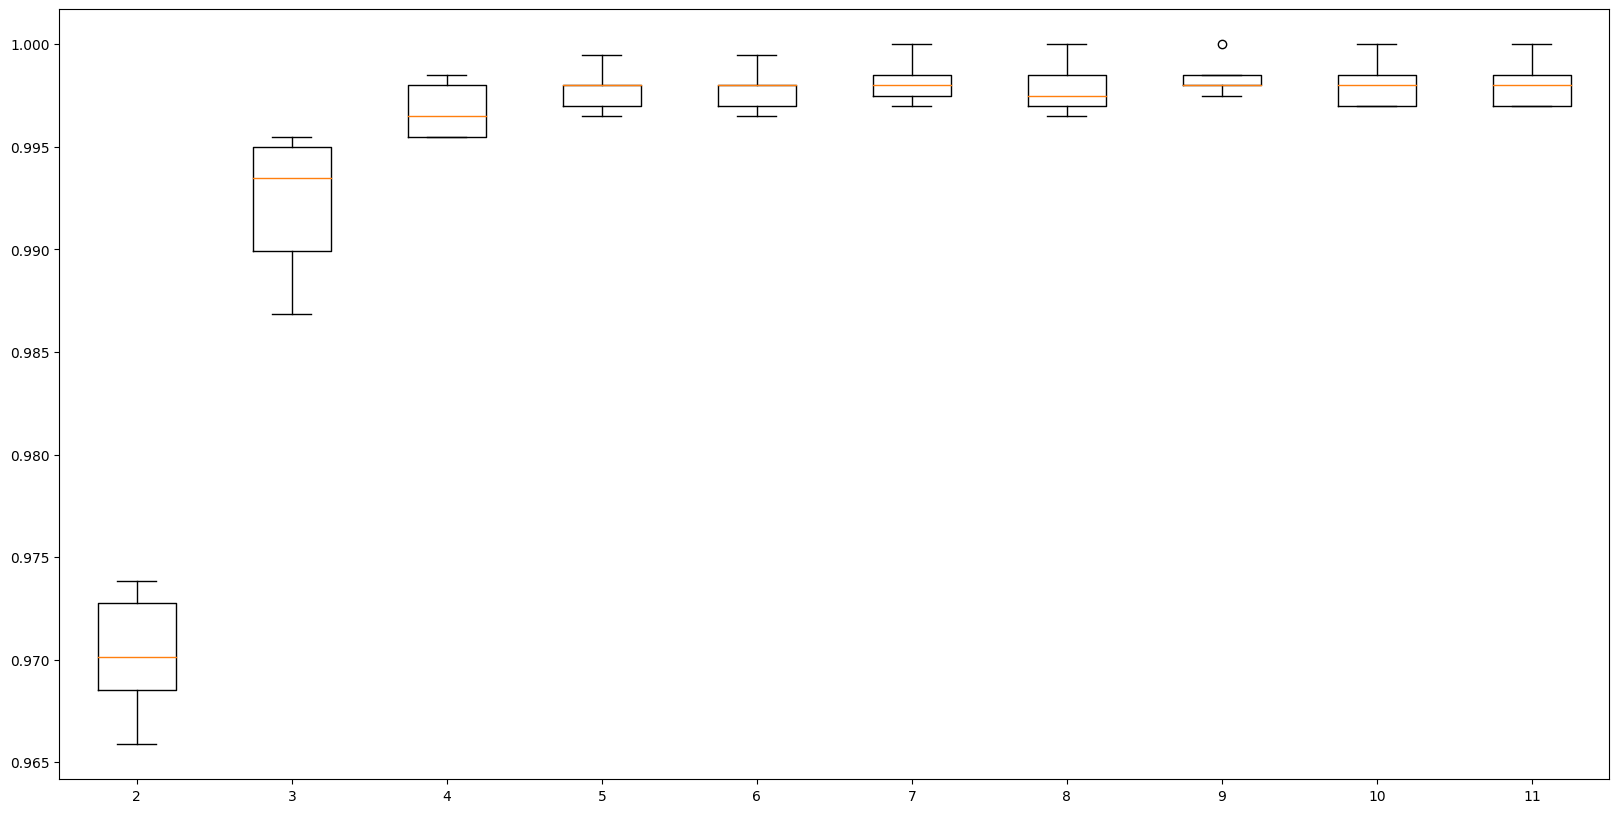

In [93]:
grid={"max_depth":[i for i in range(2, 12)]}
model=ensemble.RandomForestClassifier(n_estimators=20)
results = grid_search(grid, model, x, y)
plotGridResults(results)

#### max_features param

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10; 1/10] START clf__max_features=0.1.....................................
[CV 1/10; 1/10] END ......clf__max_features=0.1;, score=0.998 total time=   0.0s
[CV 2/10; 1/10] START clf__max_features=0.1.....................................
[CV 2/10; 1/10] END ......clf__max_features=0.1;, score=0.995 total time=   0.0s
[CV 3/10; 1/10] START clf__max_features=0.1.....................................
[CV 3/10; 1/10] END ......clf__max_features=0.1;, score=1.000 total time=   0.0s
[CV 4/10; 1/10] START clf__max_features=0.1.....................................
[CV 4/10; 1/10] END ......clf__max_features=0.1;, score=1.000 total time=   0.0s
[CV 5/10; 1/10] START clf__max_features=0.1.....................................
[CV 5/10; 1/10] END ......clf__max_features=0.1;, score=0.998 total time=   0.0s
[CV 6/10; 1/10] START clf__max_features=0.1.....................................
[CV 6/10; 1/10] END ......clf__max_features=0.

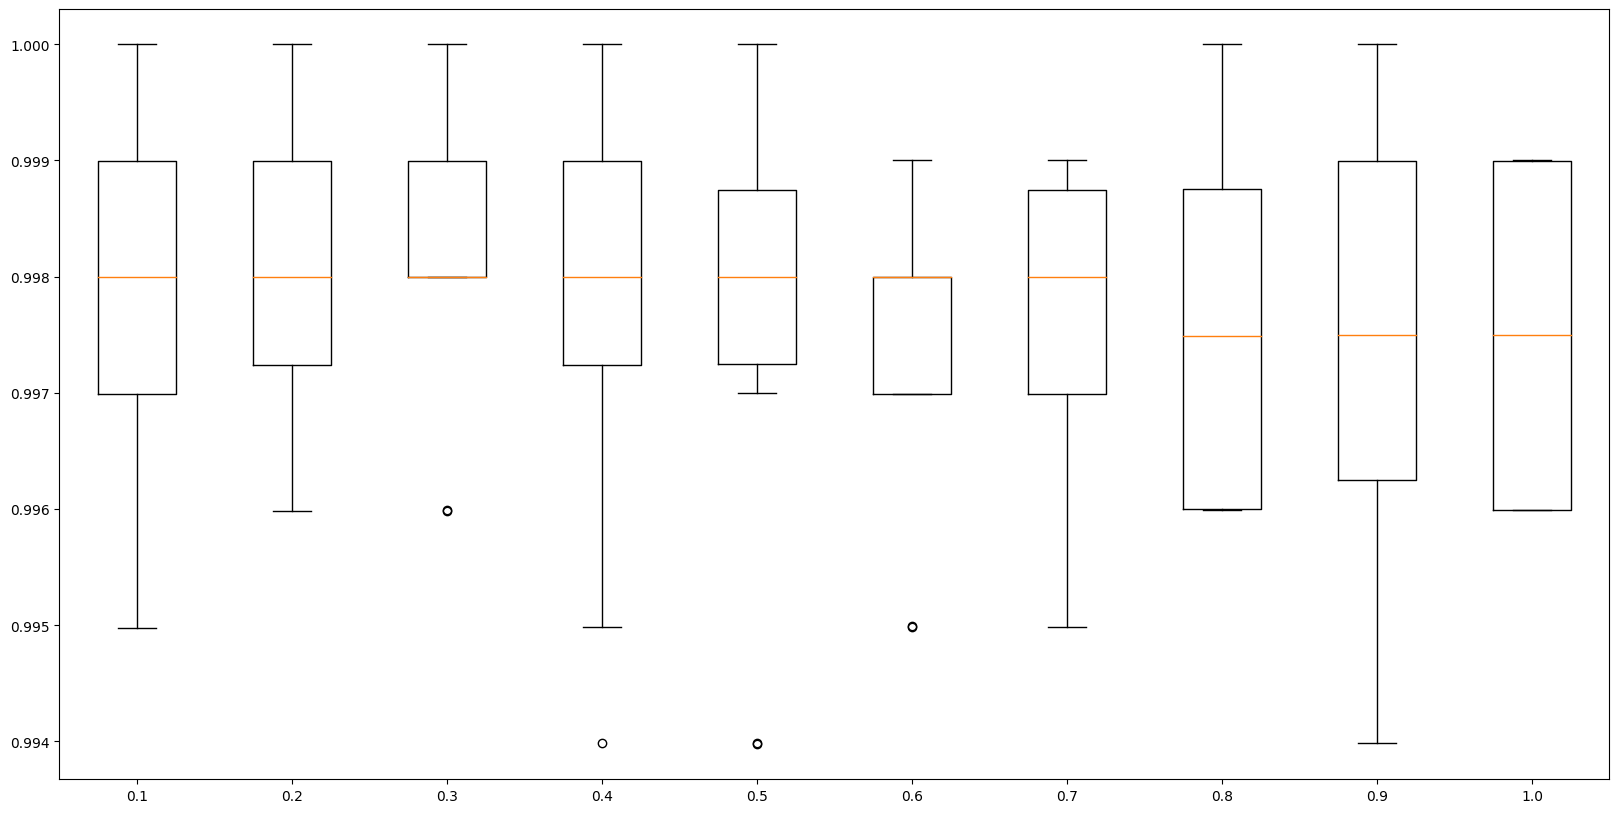

In [95]:
grid={"max_features":[i/10.0 for i in range(1, 11)]}
model=ensemble.RandomForestClassifier(n_estimators=20, max_depth = 9)
results = grid_search(grid, model, x, y, cv=10)
plotGridResults(results)

### Best RF eval

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


RF --------------------------------------
Precision:  0.9995994
Recall:  0.9966
F1:  0.99809604
ROC:  0.9999393
Accuracy:  0.9981


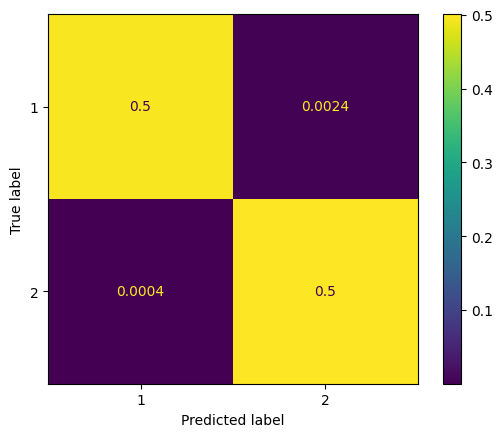

In [97]:
model = ensemble.RandomForestClassifier(
    n_estimators=20,
    max_depth=9,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=0.3
)
model_cv_rapport(model, "RF", x, y)
pipe = Pipeline([('scaler', preprocessing.StandardScaler()), ('svc', model)])
x_train, x_test, y_train, y_test = train_test_split(x.values, y.values)
pipe.fit(x_train, y_train)
ConfusionMatrixDisplay.from_estimator(pipe, x_test, y_test, cmap="viridis", normalize="all")

Ploting the Feature importance

<AxesSubplot: ylabel='feature name'>

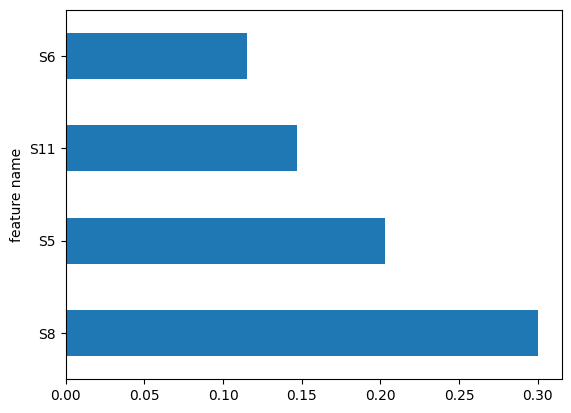

In [98]:
model.fit(x, y)
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(4).plot(xlabel= "feature name",   kind='barh')

# LGBM

We try to use this algorithm as in the litterature it appears to be as performant than XGBoost but faster to train

In [99]:
#Setting model
model = lgbm.LGBMClassifier(objective="binary", n_jobs = -1)
model_cv_rapport(model, "Non tuned LGBM", x, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.6s remaining:    0.3s


Non tuned LGBM --------------------------------------
Precision:  0.99839779
Recall:  0.9962
F1:  0.99729624
ROC:  0.9997628
Accuracy:  0.9973


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


### Hyperparameters - LightGBM
#### learning_rate param

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5; 1/16] START clf__learning_rate=0.05....................................
[CV 1/5; 1/16] END .....clf__learning_rate=0.05;, score=0.994 total time=   0.1s
[CV 2/5; 1/16] START clf__learning_rate=0.05....................................
[CV 2/5; 1/16] END .....clf__learning_rate=0.05;, score=1.000 total time=   0.0s
[CV 3/5; 1/16] START clf__learning_rate=0.05....................................
[CV 3/5; 1/16] END .....clf__learning_rate=0.05;, score=0.996 total time=   0.0s
[CV 4/5; 1/16] START clf__learning_rate=0.05....................................
[CV 4/5; 1/16] END .....clf__learning_rate=0.05;, score=0.998 total time=   0.0s
[CV 5/5; 1/16] START clf__learning_rate=0.05....................................
[CV 5/5; 1/16] END .....clf__learning_rate=0.05;, score=0.998 total time=   0.0s
[CV 1/5; 2/16] START clf__learning_rate=0.1.....................................
[CV 1/5; 2/16] END ......clf__learning_rate=0.1;

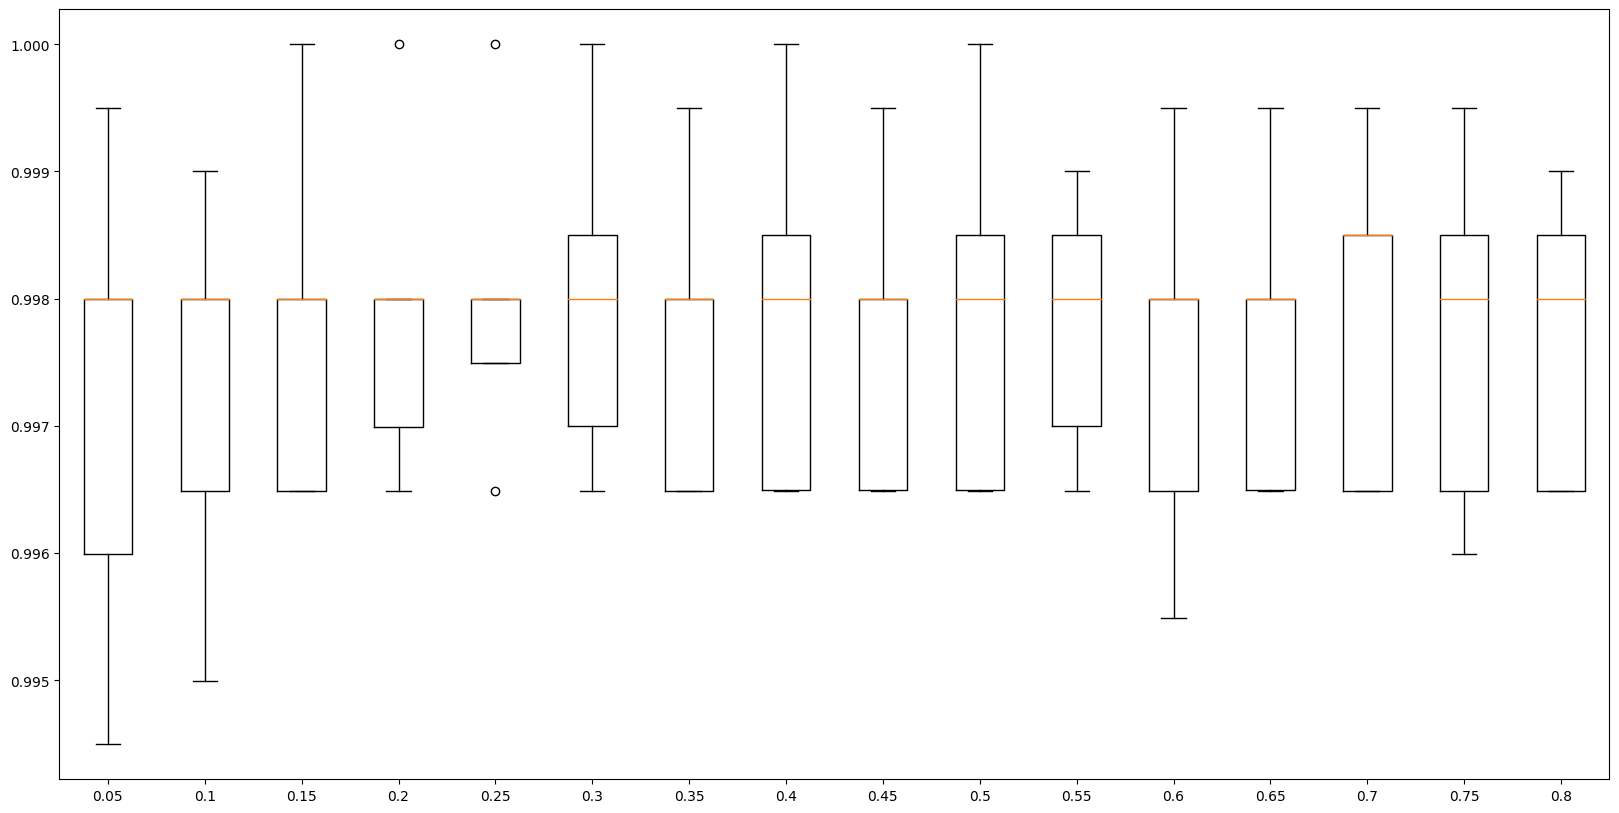

In [100]:
grid = {"learning_rate":[i*5/100.0 for i in range(1, 17)]}
model = lgbm.LGBMClassifier(objective="binary", n_jobs = -1)
results = grid_search(grid, model, x, y)
plotGridResults(results)

#### num_leaves param

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5; 1/14] START clf__num_leaves=5..........................................
[CV 1/5; 1/14] END ...........clf__num_leaves=5;, score=0.995 total time=   0.0s
[CV 2/5; 1/14] START clf__num_leaves=5..........................................
[CV 2/5; 1/14] END ...........clf__num_leaves=5;, score=1.000 total time=   0.0s
[CV 3/5; 1/14] START clf__num_leaves=5..........................................
[CV 3/5; 1/14] END ...........clf__num_leaves=5;, score=0.996 total time=   0.1s
[CV 4/5; 1/14] START clf__num_leaves=5..........................................
[CV 4/5; 1/14] END ...........clf__num_leaves=5;, score=0.998 total time=   0.0s
[CV 5/5; 1/14] START clf__num_leaves=5..........................................
[CV 5/5; 1/14] END ...........clf__num_leaves=5;, score=0.998 total time=   0.0s
[CV 1/5; 2/14] START clf__num_leaves=10.........................................
[CV 1/5; 2/14] END ..........clf__num_leaves=10;

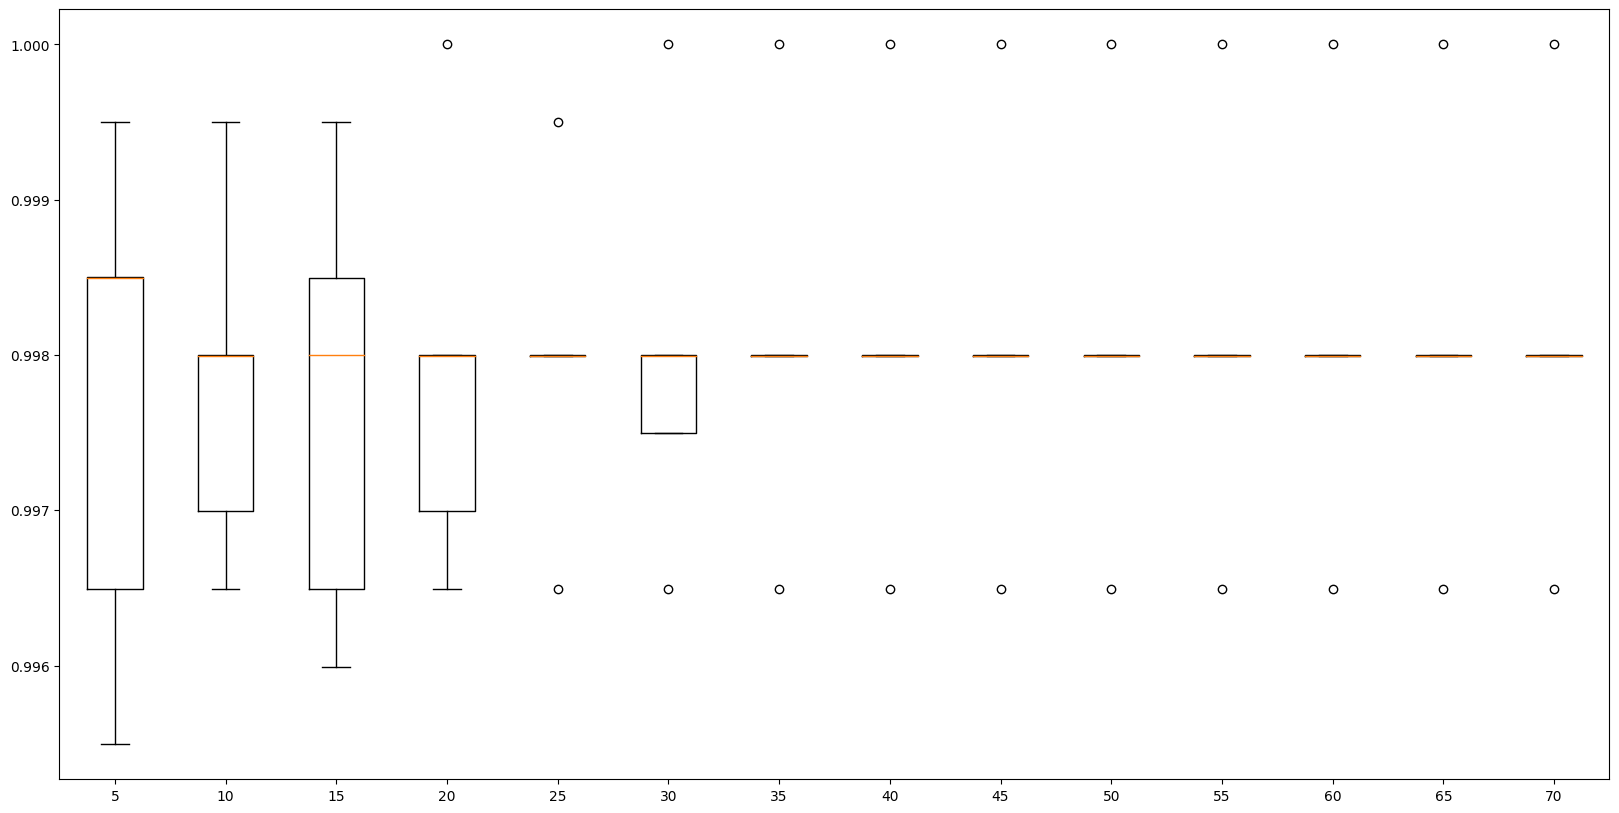

In [101]:
grid={"num_leaves":[5*i for i in range(1, 15)]}
model= lgbm.LGBMClassifier(objective="binary", n_jobs = -1, learning_rate=0.25)
results = grid_search(grid, model, x, y)
plotGridResults(results)

Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV 1/5; 1/19] START clf__num_leaves=50.........................................
[CV 1/5; 1/19] END ..........clf__num_leaves=50;, score=0.998 total time=   0.1s
[CV 2/5; 1/19] START clf__num_leaves=50.........................................
[CV 2/5; 1/19] END ..........clf__num_leaves=50;, score=1.000 total time=   0.1s
[CV 3/5; 1/19] START clf__num_leaves=50.........................................
[CV 3/5; 1/19] END ..........clf__num_leaves=50;, score=0.996 total time=   0.2s
[CV 4/5; 1/19] START clf__num_leaves=50.........................................
[CV 4/5; 1/19] END ..........clf__num_leaves=50;, score=0.998 total time=   0.1s
[CV 5/5; 1/19] START clf__num_leaves=50.........................................
[CV 5/5; 1/19] END ..........clf__num_leaves=50;, score=0.998 total time=   0.0s
[CV 1/5; 2/19] START clf__num_leaves=100........................................
[CV 1/5; 2/19] END .........clf__num_leaves=100;

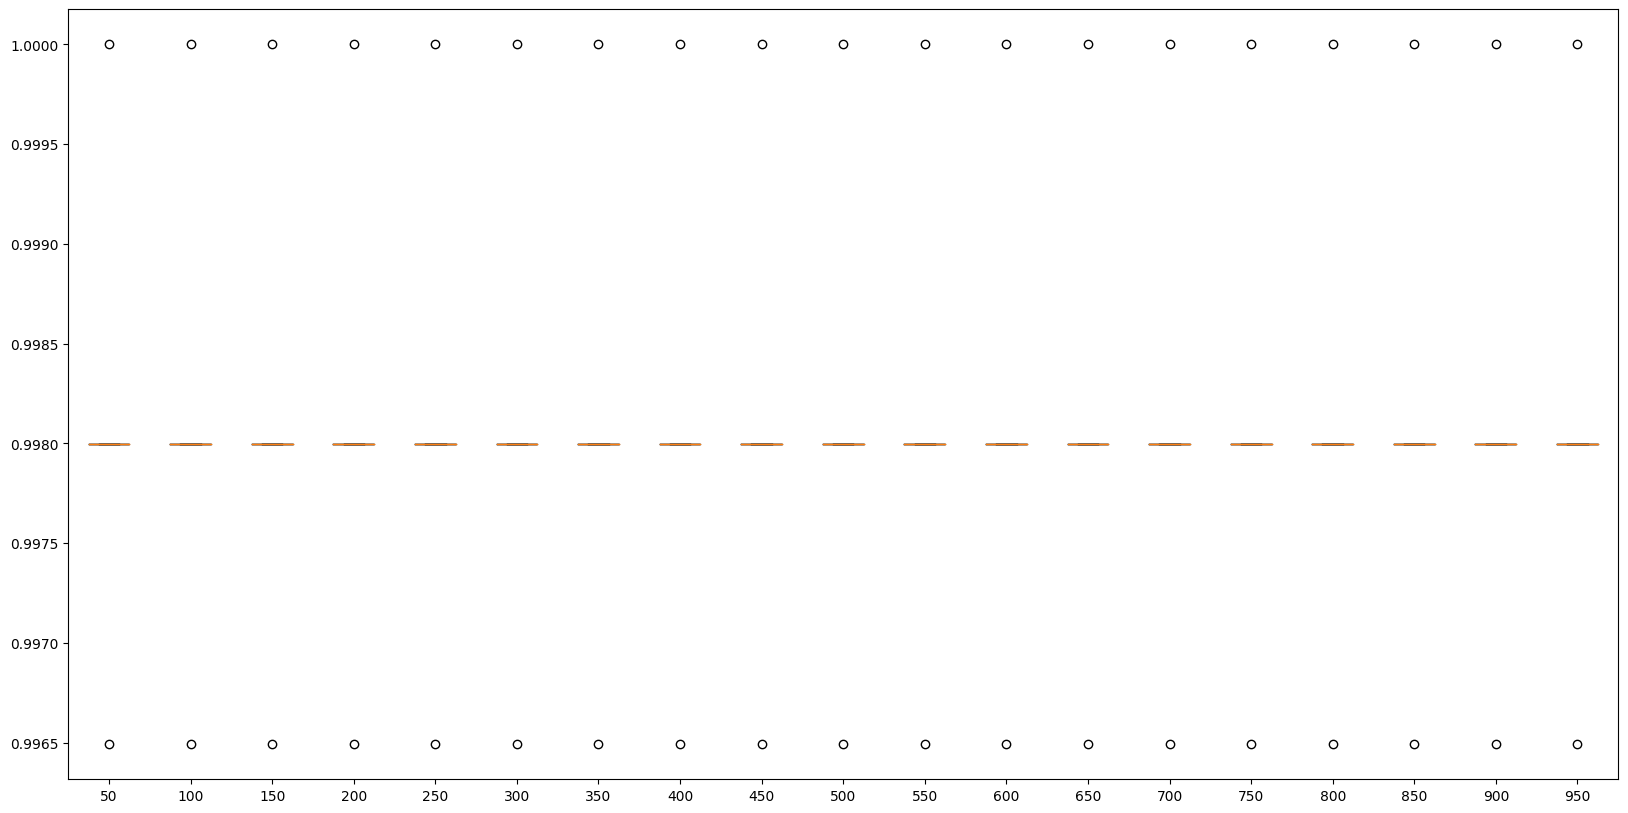

In [102]:
grid={"num_leaves":[50*i for i in range(1, 20)]}
model= lgbm.LGBMClassifier(objective="binary", n_jobs = -1, learning_rate=0.25)
results = grid_search(grid, model, x, y)
plotGridResults(results)

After 35 leaves, the results are stable so we stay at 35.

#### n_estimators param

Fitting 5 folds for each of 22 candidates, totalling 110 fits
[CV 1/5; 1/22] START clf__n_estimators=30.......................................
[CV 1/5; 1/22] END ........clf__n_estimators=30;, score=0.996 total time=   0.0s
[CV 2/5; 1/22] START clf__n_estimators=30.......................................
[CV 2/5; 1/22] END ........clf__n_estimators=30;, score=0.999 total time=   0.0s
[CV 3/5; 1/22] START clf__n_estimators=30.......................................
[CV 3/5; 1/22] END ........clf__n_estimators=30;, score=0.996 total time=   0.0s
[CV 4/5; 1/22] START clf__n_estimators=30.......................................
[CV 4/5; 1/22] END ........clf__n_estimators=30;, score=0.998 total time=   0.0s
[CV 5/5; 1/22] START clf__n_estimators=30.......................................
[CV 5/5; 1/22] END ........clf__n_estimators=30;, score=0.998 total time=   0.0s
[CV 1/5; 2/22] START clf__n_estimators=40.......................................
[CV 1/5; 2/22] END ........clf__n_estimators=40

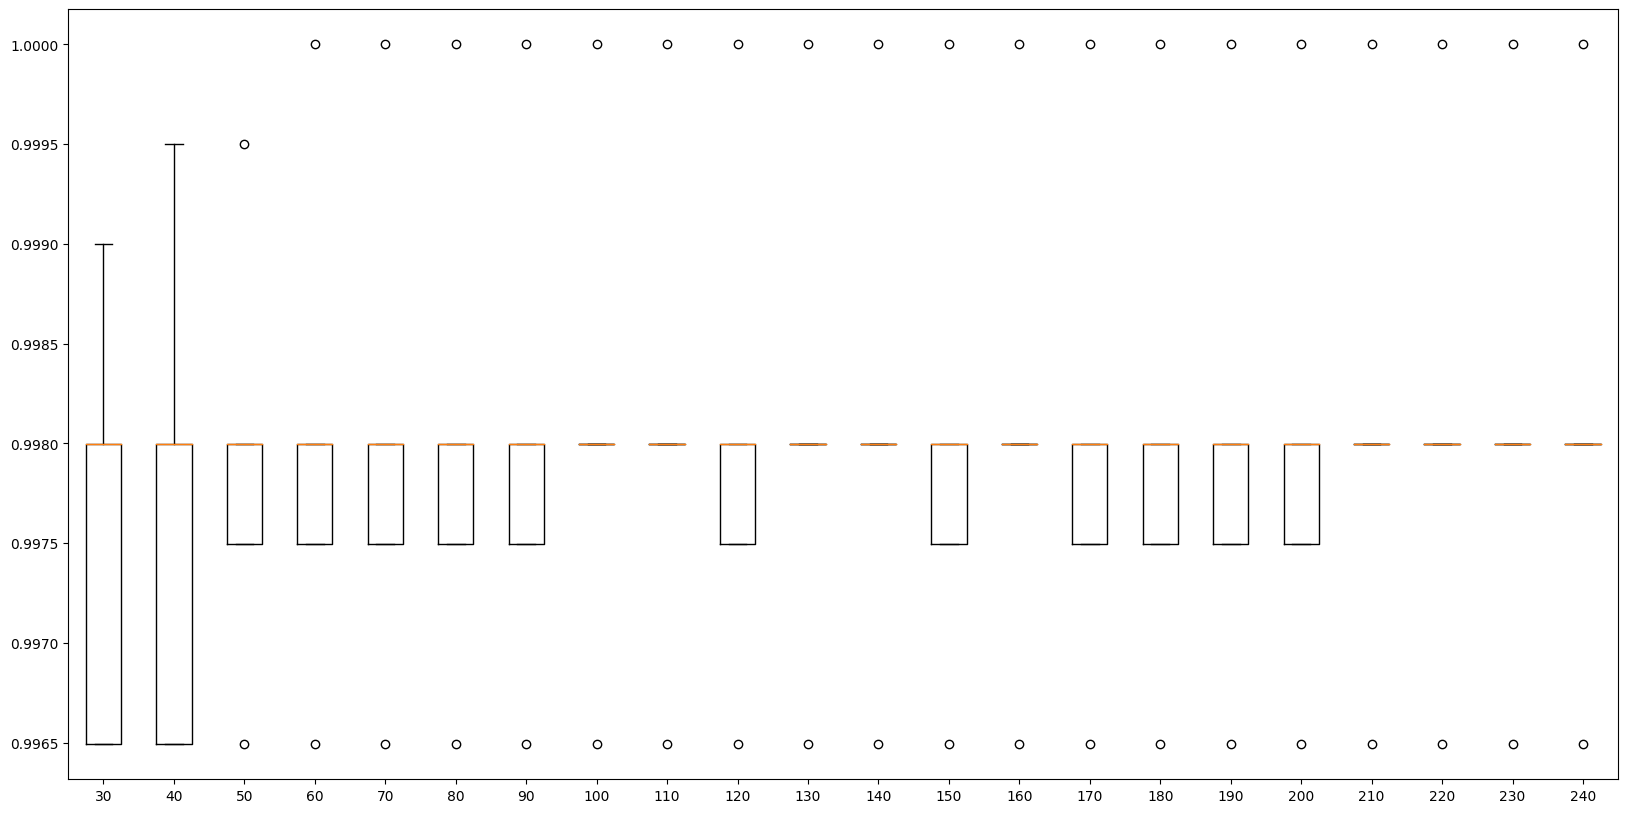

In [103]:
grid={"n_estimators":[i*10 for i in range(3, 25)]}
model = lgbm.LGBMClassifier(objective="binary", n_jobs = -1, learning_rate=0.25, num_leaves = 35)
results = grid_search(grid, model, x, y)
plotGridResults(results)

We choose n_estimator = 100 as the result average are the highest

#### max_depth param

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START clf__max_depth=2............................................
[CV 1/5; 1/9] END .............clf__max_depth=2;, score=0.996 total time=   0.0s
[CV 2/5; 1/9] START clf__max_depth=2............................................
[CV 2/5; 1/9] END .............clf__max_depth=2;, score=1.000 total time=   0.0s
[CV 3/5; 1/9] START clf__max_depth=2............................................
[CV 3/5; 1/9] END .............clf__max_depth=2;, score=0.996 total time=   0.0s
[CV 4/5; 1/9] START clf__max_depth=2............................................
[CV 4/5; 1/9] END .............clf__max_depth=2;, score=0.998 total time=   0.0s
[CV 5/5; 1/9] START clf__max_depth=2............................................
[CV 5/5; 1/9] END .............clf__max_depth=2;, score=0.998 total time=   0.0s
[CV 1/5; 2/9] START clf__max_depth=3............................................
[CV 1/5; 2/9] END .............clf__max_depth=3;,

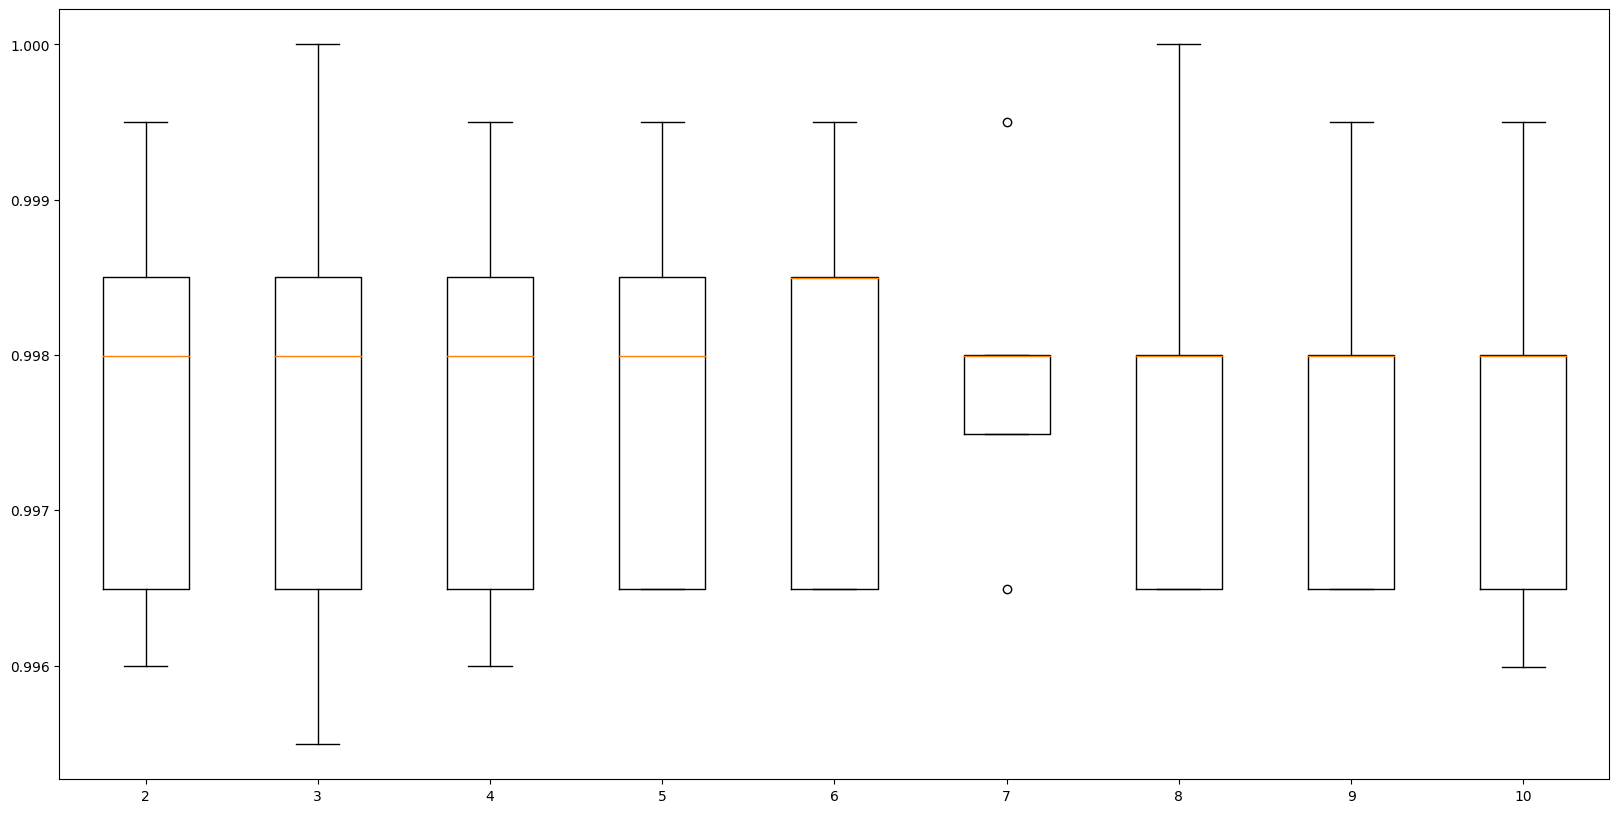

In [105]:
grid={"max_depth":[i for i in range(2, 11)]}
model= lgbm.LGBMClassifier(objective="binary", n_jobs = -1, learning_rate=0.25, n_estimators=100, num_leaves = 35)
results = grid_search(grid, model, x, y)
plotGridResults(results)

### Best LGBM eval

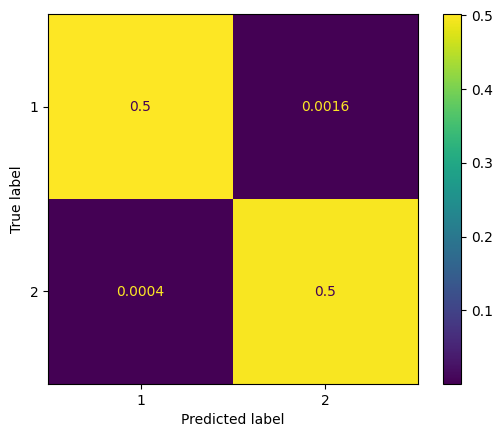

In [107]:
model = lgbm.LGBMClassifier(
    objective="binary",
    n_jobs = -1,
    learning_rate=0.25,
    n_estimators=100,
    num_leaves = 50,
    max_depth = 6
)
pipe = Pipeline([('scaler', preprocessing.StandardScaler()), ('svc', model)])
x_train, x_test, y_train, y_test = train_test_split(x.values, y.values)
pipe.fit(x_train, y_train)
ConfusionMatrixDisplay.from_estimator(pipe, x_test, y_test, cmap="viridis", normalize="all")